In [2]:
from keras.models import Sequential

model = Sequential()

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd

import keras
from keras.callbacks import ReduceLROnPlateau
# Sequential类，顺序连接，可以封装各种神经网络层，包括Dense全连接层，Dropout层，Cov2D 卷积层，等等
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [66]:
# 可视化相关
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [3]:
train = pd.read_csv('train.csv')
print(train.shape)

test = pd.read_csv('test.csv')
print(test.shape)
test.head(3)

(42000, 785)
(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
# isnull()判断是否有缺失值；
# any()返回是否有任何元素在请求轴上为真（会将DataFrame转为Series）,若axis=0则以columns为单位，若axis=1则以index为单位,axis默认为0；
# describe()对数据进行描述性统计（对象属性会返回count计数和，unique不重复的值的数量，top最常见的值的value，freq最常见的值的频率）

print(train.isnull().any().describe())


count       785
unique        1
top       False
freq        785
dtype: object


In [7]:
# 把数据变成float32更精确

x_train = train.iloc[:, 1:].values.astype('float32')
y_train = train.iloc[:, 0].values.astype('int32')

x_test = test.values.astype('float32')
x_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [8]:
# 将数据进行归一化到0-1 因为图像数据最大是255

x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (42000, 784)
42000 train samples
28000 test samples


In [28]:
# batch_size 太小会导致训练慢，过拟合等问题，太大会导致欠拟合。所以要适当选择
batch_size = 256
# 0-9手写数字一个有10个类别
num_classes = 10
# 12次完整迭代，差不多够了
epochs = 2
# 输入的图片是28*28像素的灰度图
img_rows, img_cols = 28, 28

X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  # 1 indicates that number of color channels is 1.

X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# 将类别向量(从0到nb_classes的整数向量)映射为二值类别矩阵
# 把类别0-9变成2进制，方便训练
Y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)

Y_train.shape

(42000, 10)

In [42]:
X_test.shape

(28000, 28, 28, 1)

In [8]:
input_shape = (28, 28, 1)

model = Sequential()
# 加上一个2D卷积层， 32个输出（也就是卷积通道），激活函数选用relu，
# 卷积核的窗口选用3*3像素窗口
# filters：卷积核的数目（即输出的维度）
# kernel_size：卷积核的宽度和长度。如为单个整数，则表示在各个空间维度的相同长度。
model.add(Conv2D(filters = 32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=input_shape))
# 对输入采用0.5概率的Dropout, 减少过拟合
model.add(Dropout(0.5))
# 64个通道的卷积层
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal'))
# 对输入采用0.5概率的Dropout, 减少过拟合
model.add(Dropout(0.5))
# 展平所有像素，比如[28*28] -> [784]
model.add(Flatten())
# 对所有像素使用全连接层，输出为128，激活函数选用relu
model.add(Dense(128, activation='relu'))
# 对刚才Dropout的输出采用softmax激活函数，得到最后结果0-9
model.add(Dense(num_classes, activation='softmax'))

# 模型我们使用交叉熵损失函数，最优化方法选用RMS
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

In [29]:
x_train.shape

(42000, 784)

In [33]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.4)


Train on 25200 samples, validate on 16800 samples
Epoch 1/2
25200/25200 [==============================] - 118s 5ms/step - loss: 0.0489 - acc: 0.9850 - val_loss: 0.0338 - val_acc: 0.9894
Epoch 2/2
25200/25200 [==============================] - 127s 5ms/step - loss: 0.0333 - acc: 0.9895 - val_loss: 0.0365 - val_acc: 0.9885


In [ ]:
# 绘制学习曲线

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
plt.show()

# 图片见https://blog.csdn.net/starter_____/article/details/79378548

In [ ]:
# 查看混淆矩阵
#混淆矩阵的每一列代表了预测类别 ，每一列的总数表示预测为该类别的数据的数目
# 每一行代表了数据的真实归属类别，每一行的数据总数表示该类别的数据实例的数目。

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="Blues"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 是否进行标准化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 根据验证集标签的真实值和预测值计算混淆矩阵（confusion_matrix）
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
#查看最显著的错误
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap="Greys")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

errors = (Y_pred_classes - Y_true != 0)  # 矩阵相减得到误差集（?*1）
# 使用布尔索引
Y_pred_classes_errors = Y_pred_classes[errors]  # 误差集的预测标签Y（?*1）
Y_pred_errors = Y_pred[errors]  # 误差集的预测序列（?*10）
Y_true_errors = Y_true[errors]  # 误差集的真实标签Y（?*1）
X_val_errors = X_val[errors]  # 误差集的特征X，即数字图片（?*28*28*1）

# 误差集中对错误标签的预测概率
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
# 误差集中对真实标签的预测概率，np.diagonal是返回对角线的元素
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# 排序并返回的是数组值从小到大的索引值
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [34]:
pre = model.predict(X_test)
pre

array([[  1.26594890e-09,   1.16552337e-10,   1.00000000e+00, ...,
          7.57354535e-09,   1.40163383e-08,   2.35735181e-10],
       [  9.99997854e-01,   5.87802917e-10,   8.15329429e-07, ...,
          1.72630507e-07,   7.64072539e-08,   7.82563916e-07],
       [  9.28786992e-10,   2.08413944e-08,   1.48698371e-06, ...,
          9.51246238e-06,   8.02324430e-05,   9.99840140e-01],
       ..., 
       [  4.18340552e-15,   4.95312957e-11,   1.37645260e-11, ...,
          6.55345334e-10,   1.33163462e-08,   2.29370167e-09],
       [  1.29154394e-08,   3.30129174e-10,   2.11899032e-09, ...,
          4.51883443e-06,   2.59692740e-07,   9.99880075e-01],
       [  3.28231414e-10,   1.25215627e-09,   9.99991417e-01, ...,
          2.73140000e-09,   8.40296616e-06,   4.86246288e-09]], dtype=float32)

In [37]:
y_test = np.argmax(pre, axis=1)
y_test

array([2, 0, 9, ..., 3, 9, 2])

In [45]:
submission = pd.DataFrame({'ImageId': list(range(1, len(y_test) + 1)),
                           'Label': y_test})
submission.head(3)

,ImageId,Label
0,1,2
1,2,0
2,3,9


In [39]:
submission.to_csv('final.csv', index=False, header=True)

In [41]:
pre.shape

(28000, 10)

In [61]:
X_test[i,:,:,0].shape

(28, 28)

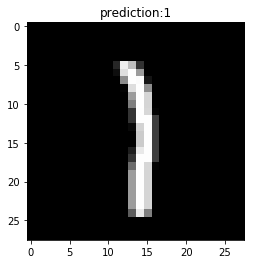

In [59]:
i=66
plt.imshow(X_test[i,:,:,0],cmap='gray')
plt.title('prediction:%d'%y_test[i])
plt.show()

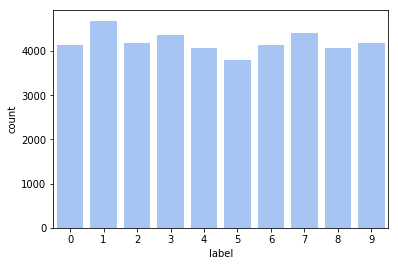

In [67]:
sns.countplot(x='label', data=train, color="#99c2ff")

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2359424   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

In [72]:
from ann_visualizer.visualize import ann_viz;
ann_viz(model)